In [1]:
import jax_sbgeom as jsb
%load_ext autoreload
%autoreload 2
import h5py
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
import numpy as onp
import sys 
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)
vmec_files = ["/home/tbogaarts/stellarator_paper/base_data/vmecs/helias3_vmec.nc4", "/home/tbogaarts/stellarator_paper/base_data/vmecs/helias5_vmec.nc4", "/home/tbogaarts/stellarator_paper/base_data/vmecs/squid_vmec.nc4"]

vmec_file = vmec_files[1]
import StellBlanket.SBGeom as SBGeom
from jax_sbgeom.flux_surfaces.flux_surfaces_base import _cartesian_position_interpolated_jit, _cylindrical_position_interpolated, _cartesian_position_interpolated_grad, ToroidalExtent, FluxSurface, FluxSurfaceData
from jax_sbgeom.flux_surfaces.flux_surface_meshing import _volume_of_mesh
from tests.flux_surfaces.flux_surface_base import test_position, _get_flux_surfaces, _sampling_grid, _1d_sampling_grid, test_normals, test_meshing_surface, test_principal_curvatures, _get_all_closed_surfaces, test_all_closed_surfaces, _mesh_to_pyvista_mesh
import pyvista as pv

Triangle Elements not compiled


In [2]:
def _get_flux_surfaces(vmec_file):
    fs_jax    = jsb.flux_surfaces.FluxSurface.from_hdf5(vmec_file)
    fs_sbgeom = SBGeom.VMEC.Flux_Surfaces_From_HDF5(vmec_file)
    return fs_jax, fs_sbgeom

fs_jax, fs_sbgeom = _get_flux_surfaces(vmec_file)  # just to compile

In [3]:
mesh = jsb.flux_surfaces.mesh_surface(fs_jax, 1.0, ToroidalExtent.full(), 100, 150)

In [4]:
@jax.jit
def Rmnc_Zmns_wrapper(Rmnc, Zmns, flux_surface):
    data_old = flux_surface.data
    fs_new = FluxSurface(FluxSurfaceData(Rmnc, Zmns, data_old.mpol_vector, data_old.ntor_vector), flux_surface.settings)
    return fs_new


def Volume_Rmnc_Zmns_wrapper(Rmnc, Zmns, flux_surface):
    fs_new = Rmnc_Zmns_wrapper(Rmnc, Zmns, flux_surface)
    points, connectivity = jsb.flux_surfaces.flux_surface_meshing._mesh_surface(fs_new, 1.0, 0.0, 2 * jnp.pi, True, 200, 300, True)
    volume = _volume_of_mesh(points, connectivity)
    return volume

def scaling_factor_wrapper(scaling , flux_surface):
    Rmnc_new = flux_surface.data.Rmnc * scaling
    Zmns_new = flux_surface.data.Zmns * scaling
    return Volume_Rmnc_Zmns_wrapper(Rmnc_new, Zmns_new, flux_surface)


print(scaling_factor_wrapper(1.0, fs_jax))
print(scaling_factor_wrapper(2.0, fs_jax))

1423.5478245837567
11388.382596670053


(72, 360, 3, 2)
(72, 360, 3)
(72, 360, 3)
[[-1830.5837871  -1829.48536779 -1825.97041377 ... -1819.49553678
  -1825.97041377 -1829.48536779]
 [-1833.90110792 -1829.54537914 -1822.44258545 ... -1827.29237981
  -1833.31433041 -1835.32121773]
 [-1833.6093295  -1829.57612567 -1821.46041112 ... -1817.42893353
  -1827.86181781 -1833.17577661]
 ...
 [-1808.25699689 -1801.70640743 -1789.69660832 ... -1796.69195075
  -1805.52549829 -1809.45874551]
 [-1833.6093295  -1833.17577661 -1827.86181781 ... -1809.51818493
  -1821.46041112 -1829.57612567]
 [-1833.90110792 -1835.32121773 -1833.31433041 ... -1812.46060334
  -1822.44258545 -1829.54537914]]
-108.10657660309009
[[  0.          33.51216388  56.74327886 ... -68.6147732  -56.74327886
  -33.51216388]
 [  3.96693231  36.87475917  59.41897041 ... -64.93711981 -53.12110874
  -29.55566137]
 [  9.98083688  41.81951861  63.14781637 ... -59.89464978 -47.50584729
  -23.36141289]
 ...
 [-17.50246985  15.93955116  41.24279607 ... -79.43674536 -68.37344921
 

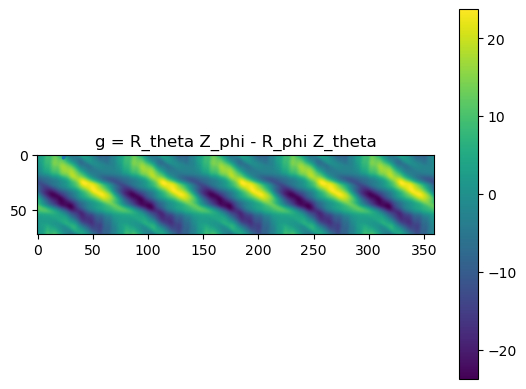

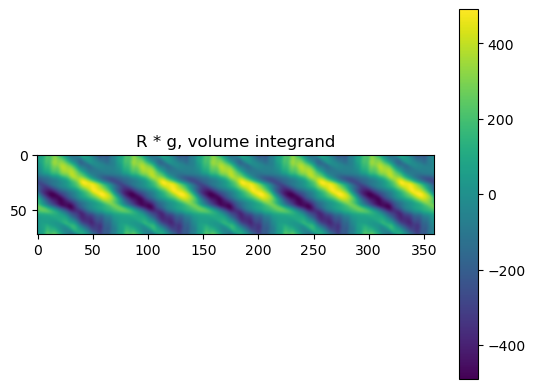

In [52]:
from jax_sbgeom.flux_surfaces.flux_surfaces_base import _cylindrical_position_interpolated, _cylindrical_position_interpolated_grad, FluxSurfaceSettings, _cartesian_position_interpolated_grad
def _volume_from_fourier(data : FluxSurfaceData, settings : FluxSurfaceSettings, s : float):

    n_theta = settings.mpol * 6
    n_phi   = settings.ntor * settings.nfp * 6
    
    theta = jnp.linspace(0, 2 * jnp.pi, n_theta, endpoint=False)
    phi   = jnp.linspace(0, 2 * jnp.pi, n_phi, endpoint=False)

    tt, pp = jnp.meshgrid(theta, phi, indexing='ij')

    RZphi = _cylindrical_position_interpolated(data, settings, s, tt, pp )

    

    R = RZphi[..., 0]
    Z = RZphi[..., 1]

    
    dRZphi_dtheta_and_dRZphi_dphi = _cylindrical_position_interpolated_grad(data, settings, s, tt, pp)

    dx_dtheta_and_dx_dphi = _cartesian_position_interpolated_grad(data, settings, s, tt, pp)

    x = _cartesian_position_interpolated_jit(data, settings, s, tt, pp)

    print(dx_dtheta_and_dx_dphi.shape)
    cross_prod = jnp.cross(dx_dtheta_and_dx_dphi[..., 0], dx_dtheta_and_dx_dphi[...,1])

    print(cross_prod.shape)
    print(x.shape)
    f2 = jnp.einsum('...i,...i->...', x, cross_prod)

    print(f2)
    

    dR_dtheta   = dRZphi_dtheta_and_dRZphi_dphi[..., 0, 0]
    dR_dphi     = dRZphi_dtheta_and_dRZphi_dphi[..., 0, 1]
    dZ_dtheta   = dRZphi_dtheta_and_dRZphi_dphi[..., 1, 0]
    dZ_dphi     = dRZphi_dtheta_and_dRZphi_dphi[..., 1, 1]
    

    print(jnp.mean(f2))

    f = R * (dR_dtheta * dZ_dphi - dR_dphi * dZ_dtheta)
    print(f)
    print(f2)
    import matplotlib.pyplot as plt
    plt.plot(R[:,0], Z[:,0])
    print(jnp.mean((dR_dtheta * dZ_dphi - dR_dphi * dZ_dtheta)))

    import matplotlib.pyplot as plt
    g = (dR_dtheta * dZ_dphi - dR_dphi * dZ_dtheta)
    plt.imshow(g)  # you’ll see positive and negative regions
    plt.colorbar()
    plt.title("g = R_theta Z_phi - R_phi Z_theta")
    plt.figure()
    plt.imshow(R*g)  # this has a net positive mean if R0>0
    plt.colorbar()
    plt.title("R * g, volume integrand")

    

_volume_from_fourier(fs_jax.data, fs_jax.settings, 1.0)

In [ ]:
volumes_f = jax.jit(jax.vmap(scaling_factor_wrapper, in_axes=(0, None)))

In [ ]:
scaling_factor  = jnp.linspace(0.1, 5.0, 1000)
volumes_scaling = volumes_f(scaling_factor, fs_jax)

2025-10-17 16:09:55.793944: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3425] Can't reduce memory use below 7.12GiB (7648125145 bytes) by rematerialization; only reduced to 35.83GiB (38478324752 bytes), down from 35.83GiB (38478324800 bytes) originally
2025-10-17 16:10:06.238244: W external/xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 35.83GiB (rounded to 38478248192)requested by op 
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-10-17 16:10:06.238403: W external/xla/xla/tsl/framework/bfc_allocator.cc:512] *___________________________________________________________________________________________________
E1017 16:10:06.238422  137700 pjrt_stream_executor_client.cc:2939] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while 

KeyboardInterrupt: 

: 

In [171]:
%timeit volumes_f(scaling_factor, fs_jax).block_until_ready()

1.01 s ± 2.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


[1.42354782e+00 1.64346116e+00 1.88493110e+00 2.14896553e+00
 2.43657236e+00 2.74875947e+00 3.08653476e+00 3.45090612e+00
 3.84288145e+00 4.26346865e+00 4.71367560e+00 5.19451020e+00
 5.70698035e+00 6.25209395e+00 6.83085888e+00 7.44428303e+00
 8.09337432e+00 8.77914062e+00 9.50258983e+00 1.02647299e+01
 1.10665686e+01 1.19091139e+01 1.27933737e+01 1.37203559e+01
 1.46910684e+01 1.57065191e+01 1.67677158e+01 1.78756665e+01
 1.90313791e+01 2.02358614e+01 2.14901213e+01 2.27951668e+01
 2.41520057e+01 2.55616460e+01 2.70250955e+01 2.85433621e+01
 3.01174537e+01 3.17483783e+01 3.34371436e+01 3.51847577e+01
 3.69922283e+01 3.88605634e+01 4.07907709e+01 4.27838587e+01
 4.48408347e+01 4.69627067e+01 4.91504827e+01 5.14051705e+01
 5.37277781e+01 5.61193133e+01 5.85807841e+01 6.11131983e+01
 6.37175638e+01 6.63948886e+01 6.91461805e+01 7.19724473e+01
 7.48746971e+01 7.78539377e+01 8.09111770e+01 8.40474229e+01
 8.72636832e+01 9.05609660e+01 9.39402790e+01 9.74026301e+01
 1.00949027e+02 1.045804

Text(0, 0.5, 'Volume [m^3]')

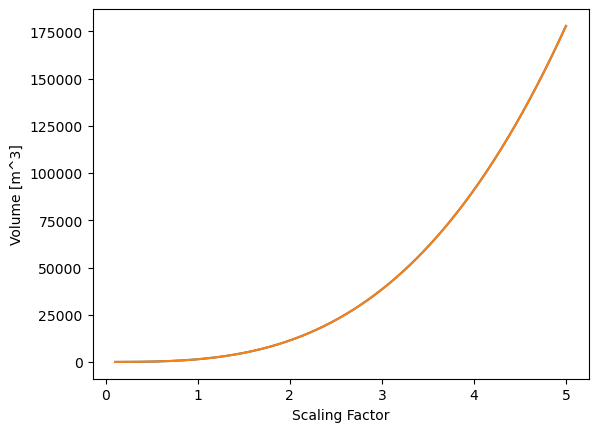

In [169]:
import matplotlib.pyplot as plt
plt.plot(scaling_factor, volumes_scaling)
plt.plot(scaling_factor, volumes_scaling[0] * (scaling_factor / 0.1)**3 )

print(volumes_scaling, volumes_scaling[0] * (scaling_factor / 0.1)**3 )

plt.xlabel("Scaling Factor")
plt.ylabel("Volume [m^3]")



In [124]:
Rmnc_2 = fs_jax.data.Rmnc 
Rmnc_3 = Rmnc_2.at[-1,1].add(1e-5)

In [125]:
(Volume_Rmnc_wrapper(Rmnc_3, fs_jax) - Volume_Rmnc_wrapper(Rmnc_2, fs_jax)) / 1e-5

Array(-2.66106235, dtype=float64)

In [126]:
volume_grad = jax.grad(Volume_Rmnc_wrapper, argnums=0)

volume_grad(fs_jax.data.Rmnc, fs_jax)

Array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [64.13706862, -2.66106234, -0.14654415, ..., -0.34602015,
         0.22644121, -0.09064209]], dtype=float64)

In [88]:
%timeit ree(fs_jax).block_until_ready()

14.5 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [80]:
%timeit volume_grad(fs_jax.data.Rmnc, fs_jax, 0.1, 0.2).block_until_ready()

42.2 ms ± 1.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [110]:
%timeit Volume_Rmnc_wrapper(fs_jax.data.Rmnc, fs_jax).block_until_ready()

9.27 ms ± 1.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [68]:
points, connectivity = mesh

mesh_pv = _mesh_to_pyvista_mesh(points, connectivity)

print(mesh_pv.volume)
_volume_of_mesh(*mesh)


1426.272235704378


Array(1426.2722357, dtype=float64)